In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import cv2
import numpy as np
from numpy import clip
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

from tqdm import tqdm

In [3]:
GLOBAL_MEAN = np.load("data/global_mean.npy")/255
GLOBAL_STD = np.load("data/global_std.npy")/255

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
resize_size = 64

transform = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=GLOBAL_MEAN, std=GLOBAL_STD)
])

data_path = 'data/data0/lsun/bedroom'
batch_size = 16

image_dataset = ImageFolder(root=data_path, transform=transform)
image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:10000])
train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

for idx, batch in enumerate(train_dataloader):
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


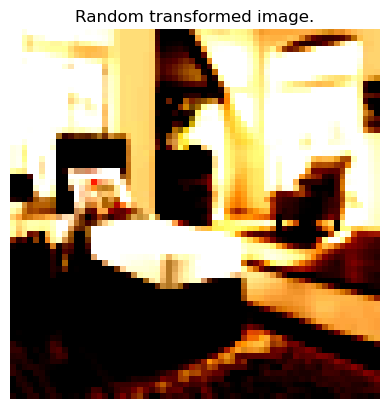

In [6]:
plt.imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
plt.title("Random transformed image.")
plt.axis('off')
plt.show()

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(Block, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.dense_time = nn.Linear(out_channels, out_channels)
        self.norm = nn.LayerNorm([out_channels, size, size])

    def forward(self, x, t):
        x_parameter = F.relu(self.conv1(x))
        time_parameter = F.relu(self.dense_time(t))
        time_parameter = t.view(-1, self.out_channels, 1, 1)
        x_parameter = x_parameter * time_parameter
        x_out = F.relu(self.conv2(x) + x_parameter)
        x_out = self.norm(x_out)
        return x_out

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_down_1 = Block(in_channels=3, out_channels=resize_size, size=resize_size)
        self.block_down_2 = Block(in_channels=resize_size, out_channels=resize_size, size=resize_size//2)
        self.block_down_3 = Block(in_channels=resize_size, out_channels=resize_size, size=resize_size//4)

        self.block_up_1 = Block(in_channels=resize_size*2, out_channels=resize_size, size=resize_size//4)
        self.block_up_2 = Block(in_channels=resize_size*2, out_channels=resize_size, size=resize_size//2)
        self.block_up_3 = Block(in_channels=resize_size*2, out_channels=resize_size, size=resize_size)

        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        self.mlp_t_initial = nn.Linear(1, resize_size)
        self.norm_t_initial = nn.LayerNorm([resize_size])

        self.mlp_dense = nn.Linear(
            resize_size + resize_size * (resize_size//4)**2, 
            resize_size*(resize_size//4)**2
            )
        self.mlp_norm = nn.LayerNorm([resize_size*(resize_size//4)**2])
        self.conv_out = nn.Conv2d(resize_size, 3, kernel_size=1, padding=0)

    def forward(self, x_img, x_ts):

        x_ts = self.mlp_t_initial(x_ts)
        x_ts = self.norm_t_initial(x_ts)
        x_ts = F.relu(x_ts)

        x1 = self.block_down_1(x_img, x_ts)
        x = self.maxpool1(x1)
        x2 = self.block_down_2(x, x_ts)
        x = self.maxpool2(x2)
        x3 = self.block_down_3(x, x_ts)
       
        x = x.view(-1, resize_size * resize_size//4 * resize_size//4)
        x = torch.cat((x, x_ts), dim=1)
        x = self.mlp_dense(x)
        x = self.mlp_norm(x)
        x = F.relu(x)
        x = x.view(-1, resize_size, resize_size//4, resize_size//4)
        
        x = torch.cat((x, x3), dim=1)
        x = self.block_up_1(x, x_ts)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        
        x = torch.cat((x, x2), dim=1)
        x = self.block_up_2(x, x_ts)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        
        x = torch.cat((x, x1), dim=1)
        x = self.block_up_3(x, x_ts)

        x = self.conv_out(x)
        return x

model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
loss_func = nn.MSELoss()

In [101]:
t = torch.full([batch_size, 1], 1, dtype=torch.float)
preds = model(batch[0].to(device), t.to(device))

In [42]:
timesteps = 16
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

In [ ]:
epochs = 10
for i in range(epochs):
    for x_img, _ in tqdm(train_dataloader, f"Epoch: {i}"):
        optimizer.zero_grad()
        x_ts = generate_ts(len(x_img))
        x_a, x_b = forward_noise(x_img, x_ts)

        x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
        x_a = x_a.float().to(device)
        x_b = x_b.float().to(device)

        y_p = model(x_a, x_ts)
        loss = torch.mean(torch.abs(y_p - x_b))
        loss.backward()
        optimizer.step()

In [102]:
x = torch.randn(batch_size, 3, resize_size, resize_size).to(device)
with torch.no_grad():
    for i in tqdm(range(16), "Predicting..."):
        t = i
        x = model(x, torch.full([batch_size, 1], t, dtype=torch.float, device=device))
        # plt.imshow(x[10].detach().permute(1, 2, 0).cpu())
        # plt.show()

Predicting...: 100%|██████████| 16/16 [00:00<00:00, 88.75it/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


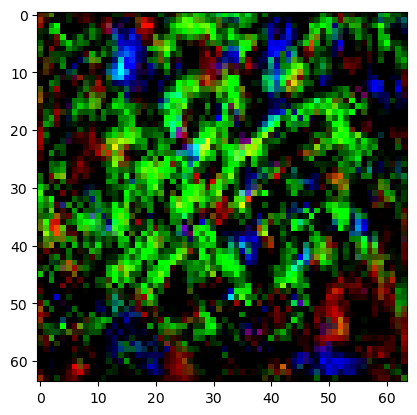

In [105]:
plt.imshow(x[8].detach().permute(1, 2, 0).cpu())
plt.show()